In [1]:
import re
import emoji
import pandas as pd
import numpy as np
import os
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import evaluate
from sklearn.metrics import precision_recall_fscore_support

DATASET_PATH = "../dataset"
MODEL_PATH = "../trained_models"

SA_DATA = DATASET_PATH + "/sa"
SA_MODEL = MODEL_PATH + "/sa"


c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv(SA_DATA + "/Restaurant_Reviews.csv")
dataset.head(10)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
print("Null count:\n", dataset.isna().sum())
print("Duplicate count:", dataset.duplicated().sum())

Null count:
 Review    0
Liked     0
dtype: int64
Duplicate count: 4


In [5]:
dataset.drop_duplicates(inplace=True)
print("Duplicate count:", dataset.duplicated().sum())

Duplicate count: 0


In [6]:
def clean_text(text):
  text = emoji.replace_emoji(text, replace='')
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text.lower()

In [7]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)

  result = metric.compute(predictions=predictions, references=labels)

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average="weighted"
  )

  return {
      "accuracy": result["accuracy"],
      "precision": precision,
      "recall": recall,
      "f1": f1,
  }

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_data(data):
  return tokenizer(data["Review"], truncation=True, padding="max_length")

In [9]:
dataset = Dataset.from_pandas(dataset.rename(columns={"Liked": "label"}))

tokenized_dataset = dataset.map(tokenize_data, batched=True)

split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset, temp_dataset = split["train"], split["test"]
split = temp_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = split["train"], split["test"]

print(len(train_dataset))
print(len(temp_dataset))
print(len(test_dataset))
print(len(valid_dataset))

Map: 100%|██████████| 996/996 [00:00<00:00, 4875.25 examples/s]

796
200
100
100


In [10]:
model_exists = (os.path.isdir(SA_MODEL) and os.path.exists(os.path.join(SA_MODEL, "config.json")))

metric = evaluate.load("accuracy")

if model_exists:
    print(f"Found trained SA model at {SA_MODEL}")

    tokenizer = DistilBertTokenizerFast.from_pretrained(SA_MODEL)
    model = DistilBertForSequenceClassification.from_pretrained(SA_MODEL)

    do_train = False

else:
    print("No trained model found. Training from scratch...")

    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )

    do_train = True


training_args = TrainingArguments(
    output_dir=SA_MODEL,
    num_train_epochs=3,  
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


if do_train:
    trainer.train()

    print(f"Saving model to {SA_MODEL}...")
    model.save_pretrained(SA_MODEL)
    tokenizer.save_pretrained(SA_MODEL)
else:
    print("Model Loaded Success")


No trained model found. Training from scratch...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.354000,0.230653,0.920000,0.924667,0.920000,0.920815
2,0.164400,0.424174,0.880000,0.902061,0.880000,0.882232
3,0.015500,0.372810,0.890000,0.897214,0.890000,0.891336


c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saving model to ../trained_models/sa...


In [11]:
metrics = trainer.evaluate(test_dataset)
print(metrics)

c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2174914926290512, 'eval_accuracy': 0.92, 'eval_precision': 0.9209955841027699, 'eval_recall': 0.92, 'eval_f1': 0.9201288244766505, 'eval_runtime': 23.8816, 'eval_samples_per_second': 4.187, 'eval_steps_per_second': 0.293, 'epoch': 3.0}


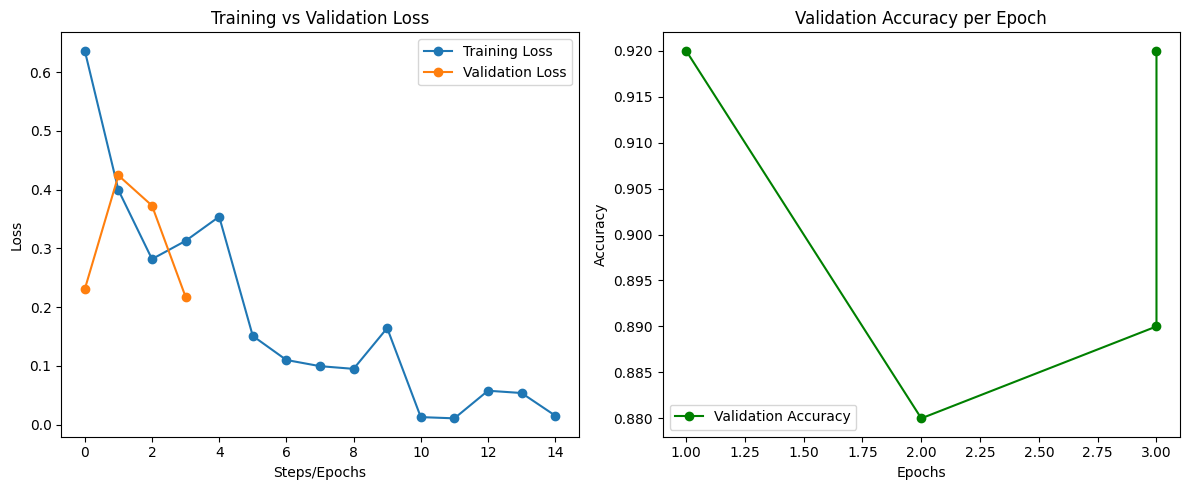

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os


save_folder = "evaluation/Sentiment_Model"
os.makedirs(save_folder, exist_ok=True)  

history = trainer.state.log_history

train_loss = []
val_loss = []
val_acc = []
epochs = []

for entry in history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        val_loss.append(entry['eval_loss'])
        val_acc.append(entry['eval_accuracy'])
        epochs.append(entry['epoch'])


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()


save_path = os.path.join(save_folder, "training_metrics.png")
plt.savefig(save_path, dpi=300) 


plt.show()

c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


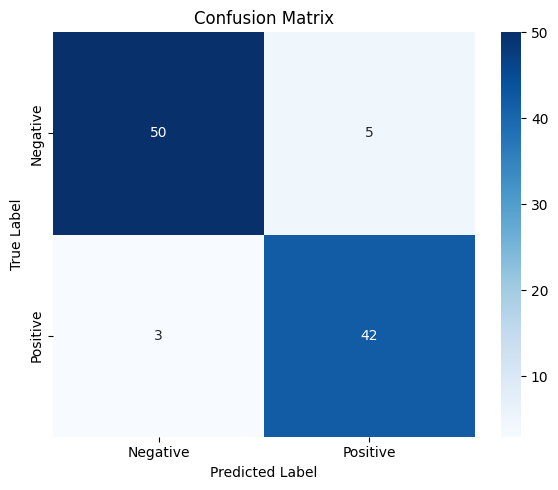

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np


save_folder = "evaluation/Sentiment_Model"
os.makedirs(save_folder, exist_ok=True)  

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids


cm = confusion_matrix(labels, preds)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()


save_path = os.path.join(save_folder, "confusion_matrix.png")
plt.savefig(save_path, dpi=300)

plt.show()